# Clustering Analysis Project – Red Wine Dataset
prepared by Ali Moshtagh 2/7/2026
AIT670:17:VA Python for Artificial Intelligence

This notebook follows the project steps:
- Load and inspect the dataset  
- Prepare (standardize) the features  
- Run **K-Means**, **Mean Shift**, and **Hierarchical (Agglomerative)** clustering  
- Evaluate with **Silhouette Score** and **Adjusted Rand Index (ARI)** (using the `quality` column as a reference label)  
- Visualize clusters with **PCA**  
- Interpret which method performed best  

> Dataset file expected in the same folder as this notebook: `winequality-red.csv` (semicolon `;` delimiter)


## 1) Import Required Libraries

In [11]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score

plt.rcParams["figure.figsize"] = (8, 5)


## 2) Load the Red Wine Dataset

**Important:** this dataset uses `;` as the separator.

In [12]:

df = pd.read_csv("winequality-red.csv", sep=";")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## 3) Inspect the Data

In [13]:

print("Shape (rows, columns):", df.shape)

print("\nColumns:")
print(df.columns.tolist())

print("\nMissing values per column:")
print(df.isna().sum())

print("\nSummary statistics:")
df.describe()


Shape (rows, columns): (1599, 12)

Columns:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

Missing values per column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Summary statistics:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


## 4) Prepare the Data

We will:
1. Separate `quality` (we **do not** use it for clustering)  
2. Standardize the remaining features with **StandardScaler**


In [14]:

y_ref = df["quality"]            # reference only (for ARI)
X = df.drop(columns=["quality"]) # clustering features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("X shape:", X.shape)
print("X_scaled shape:", X_scaled.shape)


X shape: (1599, 11)
X_scaled shape: (1599, 11)


## 5) Apply K-Means Clustering

We test k=2..10 and choose the best k using the silhouette score.


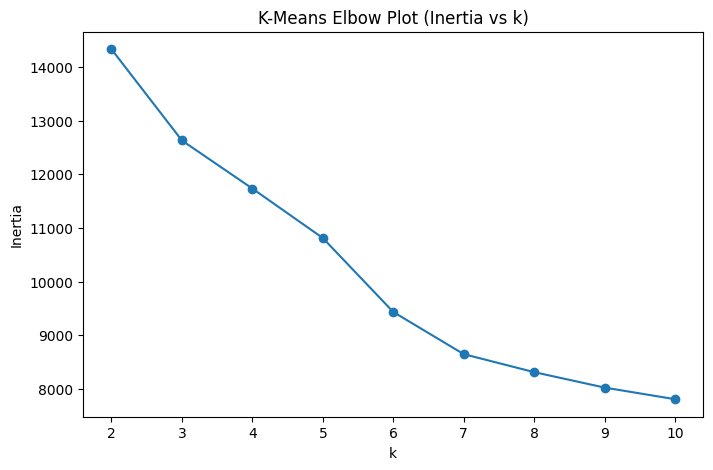

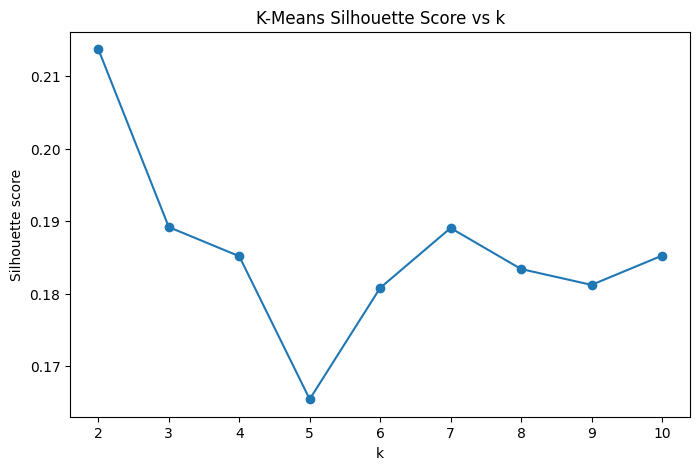

Best k by silhouette: 2


In [15]:

k_values = range(2, 11)
inertias = []
sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure()
plt.plot(list(k_values), inertias, marker="o")
plt.title("K-Means Elbow Plot (Inertia vs k)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

plt.figure()
plt.plot(list(k_values), sil_scores, marker="o")
plt.title("K-Means Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.show()

best_k = list(k_values)[int(np.argmax(sil_scores))]
print("Best k by silhouette:", best_k)


### Run K-Means with best k

In [16]:

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
kmeans_labels = kmeans.fit_predict(X_scaled)

kmeans_sil = silhouette_score(X_scaled, kmeans_labels)
kmeans_ari = adjusted_rand_score(y_ref, kmeans_labels)

print("K-Means")
print(" - clusters:", best_k)
print(" - Silhouette:", round(kmeans_sil, 4))
print(" - ARI vs quality:", round(kmeans_ari, 4))


K-Means
 - clusters: 2
 - Silhouette: 0.2137
 - ARI vs quality: 0.0433


## 6) Apply Mean Shift Clustering

Mean Shift automatically finds the number of clusters.


In [17]:

bandwidth = estimate_bandwidth(
    X_scaled,
    quantile=0.2,
    n_samples=min(500, len(df)),
    random_state=42
)
print("Estimated bandwidth:", bandwidth)

meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms_labels = meanshift.fit_predict(X_scaled)

ms_n_clusters = len(np.unique(ms_labels))
ms_sil = silhouette_score(X_scaled, ms_labels) if ms_n_clusters > 1 else float("nan")
ms_ari = adjusted_rand_score(y_ref, ms_labels)

print("Mean Shift")
print(" - clusters:", ms_n_clusters)
print(" - Silhouette:", round(ms_sil, 4))
print(" - ARI vs quality:", round(ms_ari, 4))


Estimated bandwidth: 3.2497425995387292
Mean Shift
 - clusters: 9
 - Silhouette: 0.279
 - ARI vs quality: 0.0036


## 7) Apply Hierarchical (Agglomerative) Clustering

We use the same number of clusters as K-Means (`best_k`) for a fair comparison.


In [18]:

agg = AgglomerativeClustering(n_clusters=best_k, linkage="ward")
agg_labels = agg.fit_predict(X_scaled)

agg_sil = silhouette_score(X_scaled, agg_labels)
agg_ari = adjusted_rand_score(y_ref, agg_labels)

print("Agglomerative")
print(" - clusters:", best_k)
print(" - Silhouette:", round(agg_sil, 4))
print(" - ARI vs quality:", round(agg_ari, 4))


Agglomerative
 - clusters: 2
 - Silhouette: 0.1834
 - ARI vs quality: 0.0889


## 8) Compare Results

In [19]:

results = pd.DataFrame({
    "Algorithm": ["K-Means", "Mean Shift", "Agglomerative"],
    "Num_Clusters": [len(np.unique(kmeans_labels)), len(np.unique(ms_labels)), len(np.unique(agg_labels))],
    "Silhouette": [kmeans_sil, ms_sil, agg_sil],
    "ARI_vs_quality": [kmeans_ari, ms_ari, agg_ari]
})

results


,Algorithm,Num_Clusters,Silhouette,ARI_vs_quality
0,K-Means,2,0.213730,0.043276
1,Mean Shift,9,0.278964,0.003550
2,Agglomerative,2,0.183402,0.088863


## 9) Visualize Clusters with PCA

We reduce to 2D using PCA and plot the clusters.


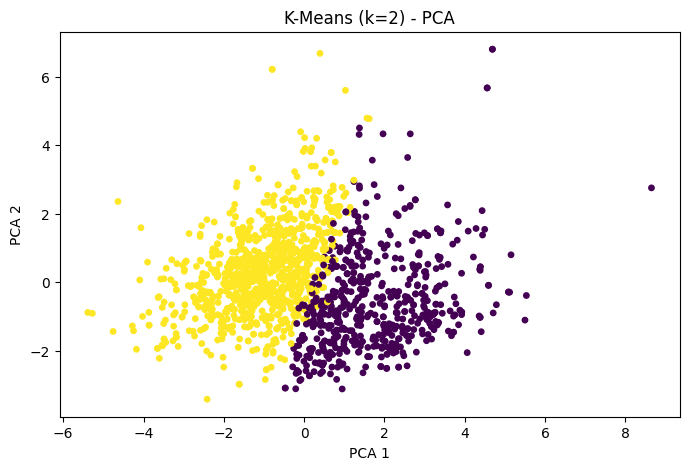

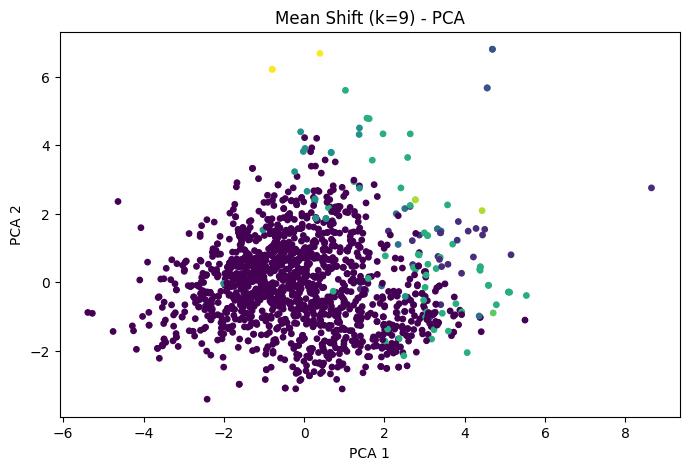

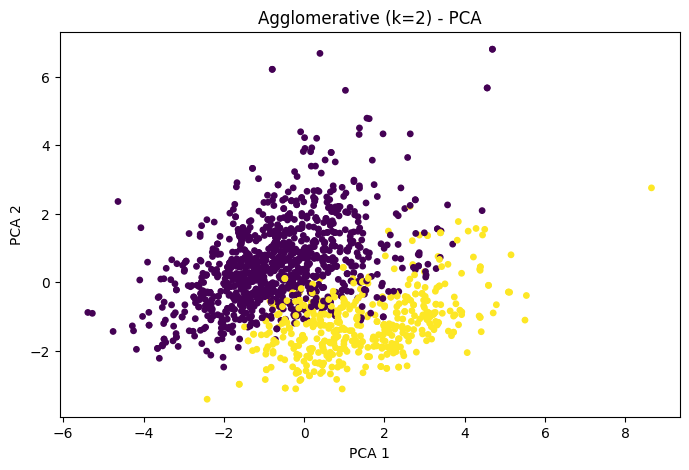

Total explained variance (2 PCA components): 0.4568


In [20]:

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

def plot_clusters(labels, title):
    plt.figure()
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=15)
    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.show()

plot_clusters(kmeans_labels, f"K-Means (k={best_k}) - PCA")
plot_clusters(ms_labels, f"Mean Shift (k={len(np.unique(ms_labels))}) - PCA")
plot_clusters(agg_labels, f"Agglomerative (k={best_k}) - PCA")

print("Total explained variance (2 PCA components):", round(pca.explained_variance_ratio_.sum(), 4))


## 10) Interpret Results

- **Clusters** group wines that have similar chemistry (acidity, sugar, alcohol, sulfates, etc.).  
- **Silhouette score** tells how clean the clusters are (higher = better separation).  
- **ARI** compares clusters to the `quality` score (reference only, because clustering is unsupervised).

**Pick the “best” algorithm** mainly by the highest silhouette score, and use the PCA plots to see if clusters look separated.
